<a href="https://colab.research.google.com/github/kunal-git-002/Detectron-2/blob/master/pt4_use_pandas_df.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***pt4 : convert our data of keypoints into pandas Dataframe***





In [189]:
from google.colab.patches import cv2_imshow
import cv2
import pandas as pd

In [190]:

# install dependencies: 
!pip install pyyaml==5.1 pycocotools>=2.0.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

1.6.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [191]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.6)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
assert torch.__version__.startswith("1.6")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html


In [192]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

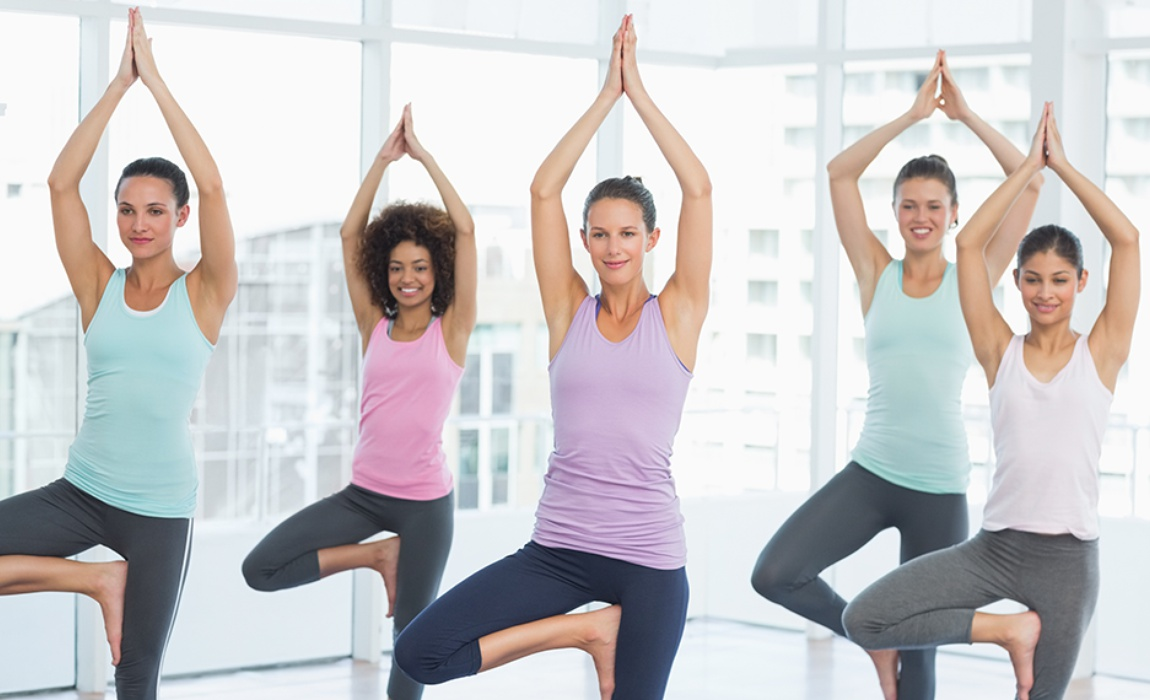

In [193]:
def read_img(path):
  img=cv2.imread(path)
  h,w,ch=img.shape

  new_h=700
  ratio=h/new_h

  new_w=int(w/ratio)

  return cv2.resize(img,(new_w,new_h))

img = read_img("/content/drive/My Drive/imgs/more8.jpg")

cv2_imshow(img)

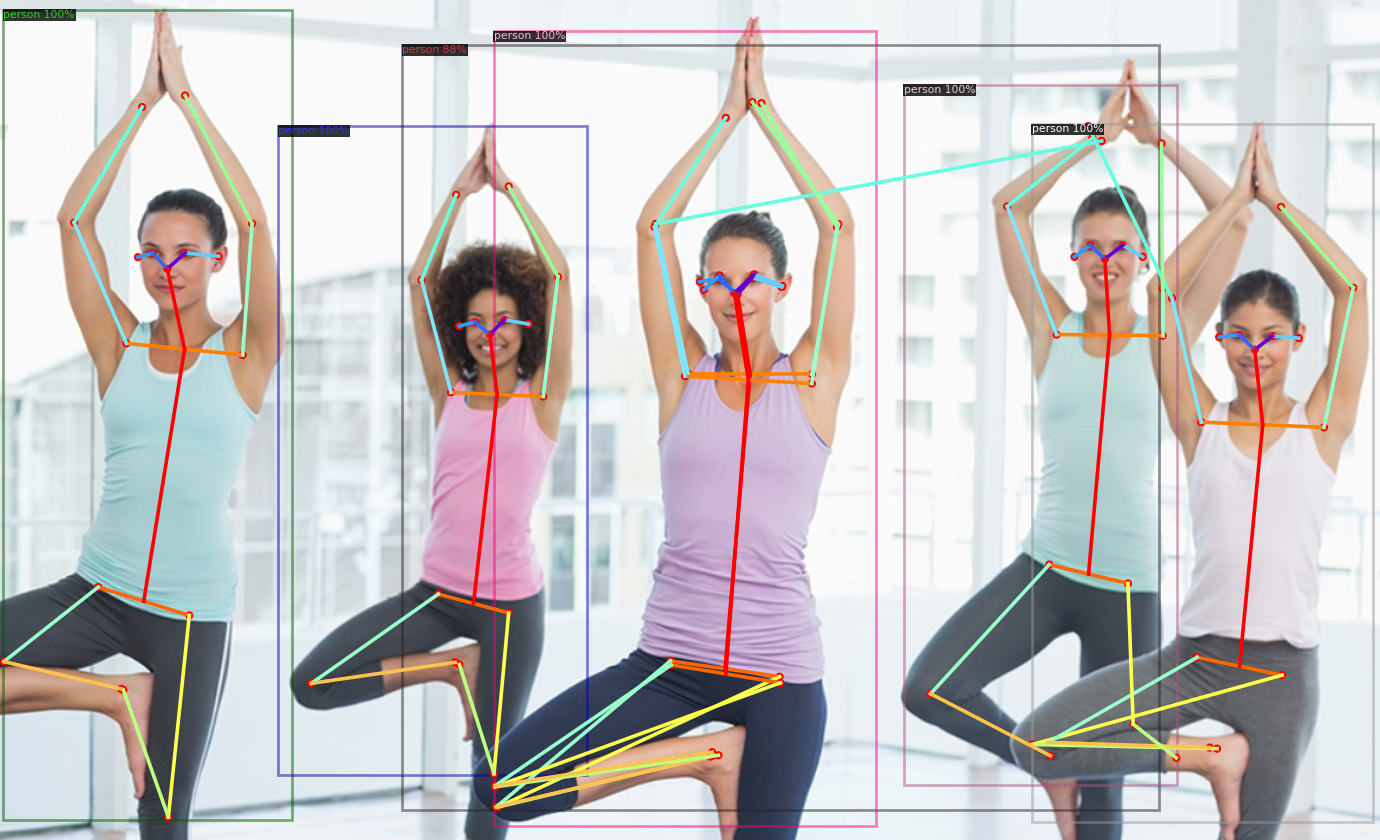

In [194]:
# Inference with a keypoint detection model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

outputs = predictor(img)#return a dictionaries

v = Visualizer(img[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

cv2_imshow(out.get_image()[:, :, ::-1])

***step 1 : getting all the information***

In [195]:

ins=outputs["instances"]#create output instance

op_data=ins.get_fields()#this return a all the imp data like, bboxes,confidence score,keypoints locations & classes

keypoints_data=op_data["pred_keypoints"]

#conversion of data into numpy array

#data is first moved to cpu and then converted to numpy array
keypoints_data = keypoints_data.cpu().data.numpy()

#now numpy array
keypoints_data=keypoints_data=np.array(keypoints_data)

In [196]:
keypoints_data.shape

(6, 17, 3)

In [ ]:
n,k,_=keypoints_data.shape
#n=num of instanves
#k=num of keypoints per instances
#_=3 ,becz we have three values (x,y,visbility)

#indexes of human keypoints according Detectron 2 keypoints model
human_keypoints={0: 'nose',
 1: 'left_eye',
 2: 'right_eye',
 3: 'left_ear',
 4: 'right_ear',
 5: 'left_shoulder',
 6: 'right_shoulder',
 7: 'left_elbow',
 8: 'right_elbow',
 9: 'left_wrist',
 10: 'right_wrist',
 11: 'left_hip',
 12: 'right_hip',
 13: 'left_knee',
 14: 'right_knee',
 15: 'left_ankle',
 16: 'right_ankle'}

all_kps={}

for i in range(n):
  kps=keypoints_data[i]

  temp_dic={}
  for j in range(len(kps)):

    x,y,vis=kps[j]
    #x,y,vis=int(x),int(y),int(vis)
    temp_dic[j]=(human_keypoints[j],
                 (x,y))
  
  all_kps[i]=temp_dic


***Convert our data into pandas dataframe***

In [ ]:
kps=[i for i in human_keypoints.values()]
keypoints_locs_df=pd.DataFrame(data=kps)
keypoints_locs_df.rename(columns={0:"human part"},inplace=True)

for ins in range(n):
  kps=all_kps[ins]
  temp_li=[]
  for ind,val in kps.items():
    part,locs=val
    temp_li.append(locs)
  keypoints_locs_df["person "+str(ins)+" (x,y)"]=temp_li

keypoints_locs_df.set_index("human part",drop=True)



***visulize the data***

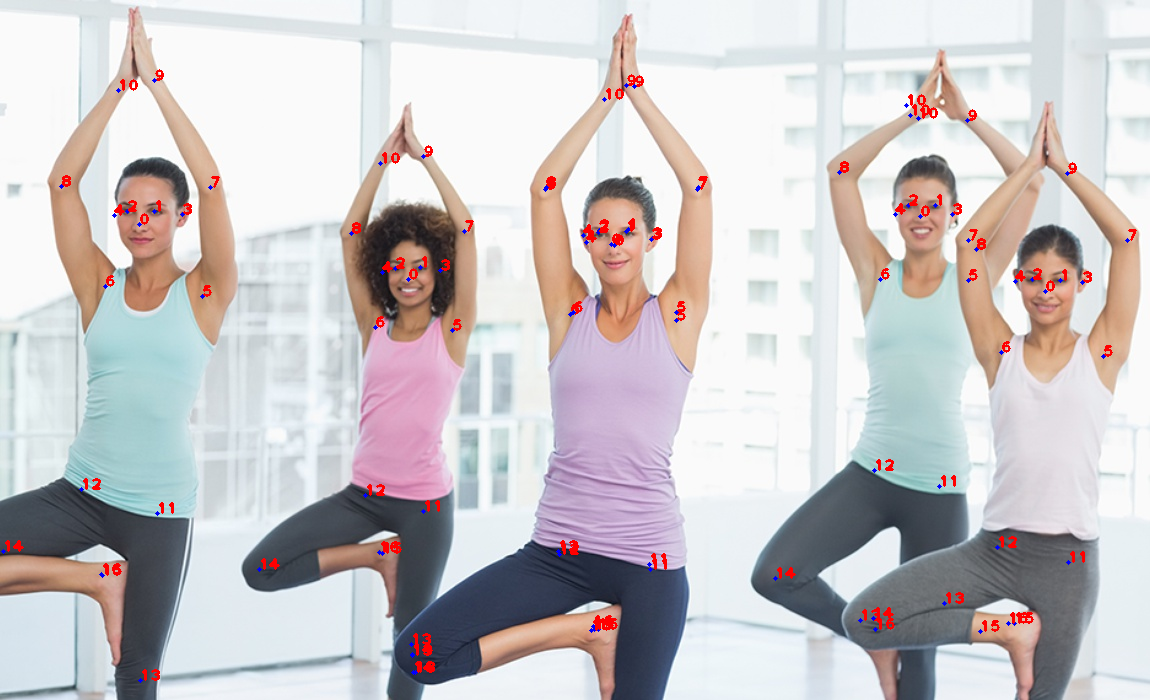

In [200]:
for col in keypoints_locs_df.columns[1:]: 
  for i in range(k):
    x,y=keypoints_locs_df[col][i]
    locs=(int(x),int(y))
    cv2.circle(img,
               locs,
               2,
               (255,0,0),
               -1)
    font=cv2.FONT_HERSHEY_PLAIN
    cv2.putText(img,
                str(i),
                locs,
                font,
                1,
                (0,0,255),
                2)
cv2_imshow(img)

***draw a line***